In [7]:
# =============================================================================
# LENDING CLUB LOAN ANALYSIS - PART 4: OFFLINE REINFORCEMENT LEARNING
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings

warnings.filterwarnings('ignore')

print("=" * 80)
print("ENHANCED OFFLINE REINFORCEMENT LEARNING FOR LOAN APPROVAL")
print("=" * 80 + "\n")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

ENHANCED OFFLINE REINFORCEMENT LEARNING FOR LOAN APPROVAL

Using device: cpu



In [8]:
# =============================================================================
# STEP 1: LOAD AND PREPARE DATA
# =============================================================================
print("=" * 80)
print("STEP 1: Load and Prepare Data")
print("=" * 80 + "\n")

print("Loading cleaned dataset...")
# Ensure this file exists in your directory
df = pd.read_csv('cleaned_lending_data.csv')
print(f"✓ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Define features and target
feature_cols = [col for col in df.columns 
                if col not in ['loan_status_binary', 'loan_status', 'reward']]
X = df[feature_cols].copy()

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Convert to numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())

# Engineer reward function
def calculate_reward(row):
    """Enhanced reward function with risk-adjusted returns"""
    loan_amnt = row['loan_amnt']
    int_rate = row['int_rate']
    loan_status = row['loan_status_binary']
    
    if loan_status == 0:  # Fully Paid
        # Profit from interest
        reward = loan_amnt * (int_rate / 100.0)
    else:  # Defaulted
        # Loss of principal
        reward = -loan_amnt
    
    return reward

# Calculate RAW rewards (Real Dollars)
df['reward'] = df.apply(calculate_reward, axis=1)
rewards_raw = df['reward'].values
outcomes = df['loan_status_binary'].values

# --- FIX: SCALE REWARDS ---
# Neural networks crash with large numbers (like 10,000). 
# We scale them to a small range (e.g., -10 to 10) for training.
print("Scaling rewards for training stability...")
reward_scaler = RobustScaler()
rewards_scaled = reward_scaler.fit_transform(rewards_raw.reshape(-1, 1)).flatten()

# Clip extreme outliers to prevent gradient explosion
rewards_scaled = np.clip(rewards_scaled, -10, 10)

print(f"✓ Calculated rewards. Range: ${rewards_raw.min():,.2f} to ${rewards_raw.max():,.2f}")
print(f"✓ Scaled rewards for NN. Range: {rewards_scaled.min():.2f} to {rewards_scaled.max():.2f}\n")

# Train-test split
# We split X, Scaled Rewards (for training), Raw Rewards (for evaluation), and Outcomes
X_train, X_test, r_train_scaled, r_test_scaled, r_train_raw, r_test_raw, y_train, y_test = train_test_split(
    X, rewards_scaled, rewards_raw, outcomes, test_size=0.2, random_state=42, stratify=outcomes
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples\n")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Safety check for NaNs introduced during scaling
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
# Note: We use the SCALED rewards for training the tensor
rewards_train_tensor = torch.FloatTensor(r_train_scaled).to(device)

STEP 1: Load and Prepare Data

Loading cleaned dataset...
✓ Dataset loaded: 1,268,685 rows × 22 columns

Scaling rewards for training stability...
✓ Calculated rewards. Range: $-40,000.00 to $12,396.00
✓ Scaled rewards for NN. Range: -10.00 to 6.65

Training set: 1,014,948 samples
Test set: 253,737 samples



In [9]:
# =============================================================================
# STEP 2: ENHANCED Q-NETWORK ARCHITECTURE
# =============================================================================
print("=" * 80)
print("STEP 2: Enhanced Q-Network Architecture")
print("=" * 80 + "\n")

class EnhancedQNetwork(nn.Module):
    """
    Enhanced Q-Network with:
    - Dueling DQN architecture
    - Batch Norm & Dropout for regularization
    """
    def __init__(self, state_dim, action_dim=2, hidden_dims=[256, 128, 64]):
        super(EnhancedQNetwork, self).__init__()
        
        # Shared feature extraction layers
        self.feature_layers = nn.ModuleList()
        prev_dim = state_dim
        for hidden_dim in hidden_dims:
            self.feature_layers.append(nn.Linear(prev_dim, hidden_dim))
            self.feature_layers.append(nn.BatchNorm1d(hidden_dim))
            self.feature_layers.append(nn.ReLU())
            self.feature_layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        
        # Dueling DQN: Separate value and advantage streams
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[-1], 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[-1], 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        
    def forward(self, state):
        x = state
        for layer in self.feature_layers:
            x = layer(x)
        
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# Initialize networks
state_dim = X_train_scaled.shape[1]
q_network = EnhancedQNetwork(state_dim).to(device)
target_network = EnhancedQNetwork(state_dim).to(device)
target_network.load_state_dict(q_network.state_dict())

print("Enhanced Q-Network Architecture:")
print("-" * 80)
print(q_network)
print(f"\nTotal parameters: {sum(p.numel() for p in q_network.parameters()):,}\n")

STEP 2: Enhanced Q-Network Architecture

Enhanced Q-Network Architecture:
--------------------------------------------------------------------------------
EnhancedQNetwork(
  (feature_layers): ModuleList(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (value_stream): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  

STEP 3: Conservative Q-Learning Training

Training Enhanced RL Agent...
--------------------------------------------------------------------------------
Epoch [1/50] Loss: 6.6969 (Bellman: 6.1767, CQL: 1.0403)
Epoch [10/50] Loss: 6.5742 (Bellman: 6.0379, CQL: 1.0725)
Epoch [20/50] Loss: 6.5528 (Bellman: 6.0144, CQL: 1.0768)
Epoch [30/50] Loss: 6.5436 (Bellman: 6.0045, CQL: 1.0781)
Epoch [40/50] Loss: 6.5364 (Bellman: 5.9974, CQL: 1.0779)
Epoch [50/50] Loss: 6.5312 (Bellman: 5.9916, CQL: 1.0791)

✓ Training completed!

✓ Saved: enhanced_rl_training_fixed.png



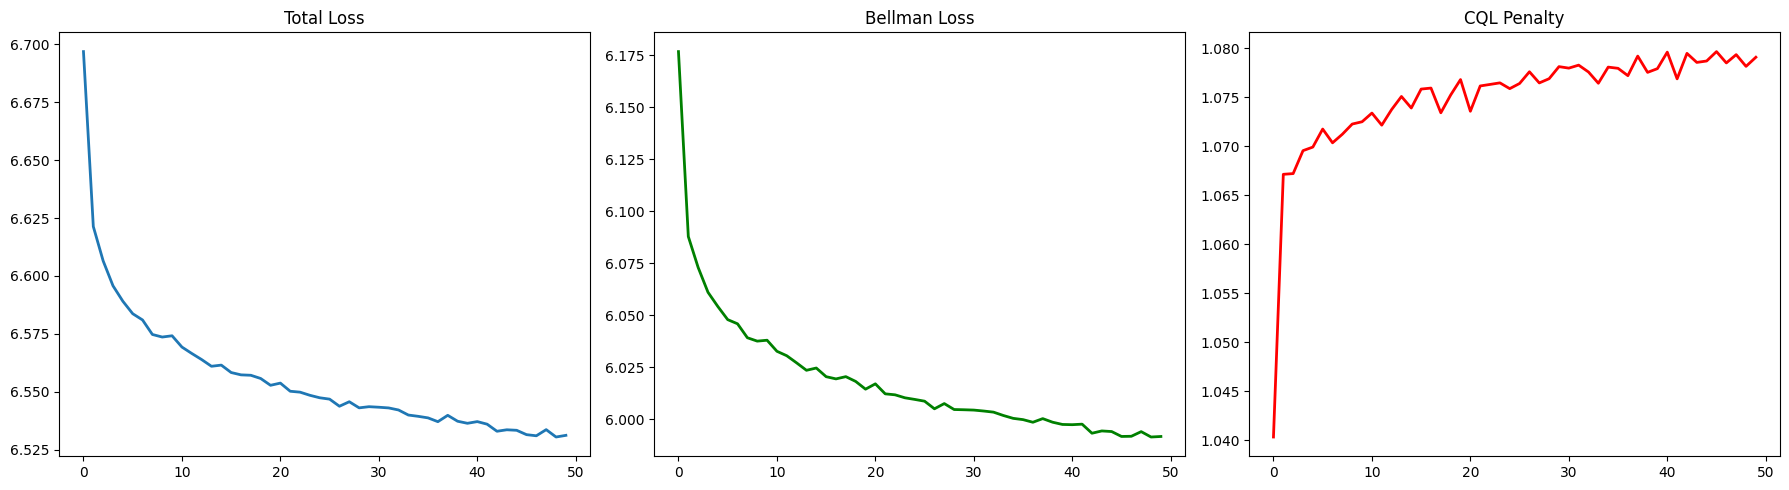

In [10]:
# =============================================================================
# STEP 3: CONSERVATIVE Q-LEARNING (CQL) TRAINING
# =============================================================================
print("=" * 80)
print("STEP 3: Conservative Q-Learning Training")
print("=" * 80 + "\n")

class CQLTrainer:
    def __init__(self, q_network, target_network, lr=0.0001, gamma=0.99, 
                 tau=0.005, cql_alpha=1.0):
        self.q_network = q_network
        self.target_network = target_network
        self.optimizer = optim.Adam(q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.tau = tau
        self.cql_alpha = cql_alpha
        self.mse_loss = nn.MSELoss()
        
    def compute_cql_loss(self, states, rewards):
        # Get current Q-values
        current_q = self.q_network(states)
        
        # Target construction for Offline RL
        # Action 0 (Deny): We assign target 0.
        # Action 1 (Approve): We assign the actual scaled reward.
        target_q = torch.zeros_like(current_q)
        target_q[:, 0] = 0.0      
        target_q[:, 1] = rewards  
        
        # Bellman Error (MSE)
        bellman_loss = self.mse_loss(current_q, target_q)
        
        # CQL Regularization (Conservative Penalty)
        # Penalize high Q-values for actions that might be out-of-distribution
        # LogSumExp gives a "soft max" of Q values
        logsumexp_q = torch.logsumexp(current_q, dim=1).mean()
        # Maximize Q-value for the action we actually have data for (Action 1 approx)
        dataset_q = current_q[:, 1].mean()
        
        conservative_penalty = logsumexp_q - dataset_q
        
        # Total Loss
        total_loss = bellman_loss + self.cql_alpha * conservative_penalty
        
        return total_loss, bellman_loss, conservative_penalty
    
    def soft_update(self):
        for target_param, param in zip(self.target_network.parameters(), 
                                       self.q_network.parameters()):
            target_param.data.copy_(
                self.tau * param.data + (1.0 - self.tau) * target_param.data
            )
    
    def train_step(self, states, rewards):
        loss, bellman_loss, cql_penalty = self.compute_cql_loss(states, rewards)
        
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping prevents NaN if gradients get too large
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        self.soft_update()
        return loss.item(), bellman_loss.item(), cql_penalty.item()

# Initialize trainer
trainer = CQLTrainer(q_network, target_network, lr=0.0001, cql_alpha=0.5)

# Training parameters
num_epochs = 50 # Reduced slightly for speed, increase if needed
batch_size = 1024
train_losses, bellman_losses, cql_penalties = [], [], []

print("Training Enhanced RL Agent...")
print("-" * 80)

# Create data loader
train_dataset = TensorDataset(X_train_tensor, rewards_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_bellman = 0.0
    epoch_cql = 0.0
    num_batches = 0
    
    for batch_states, batch_rewards in train_loader:
        loss, bellman, cql = trainer.train_step(batch_states, batch_rewards)
        epoch_loss += loss
        epoch_bellman += bellman
        epoch_cql += cql
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    avg_bellman = epoch_bellman / num_batches
    avg_cql = epoch_cql / num_batches
    
    train_losses.append(avg_loss)
    bellman_losses.append(avg_bellman)
    cql_penalties.append(avg_cql)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.4f} "
              f"(Bellman: {avg_bellman:.4f}, CQL: {avg_cql:.4f})")

print("\n✓ Training completed!\n")

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(train_losses, linewidth=2); axes[0].set_title('Total Loss')
axes[1].plot(bellman_losses, color='green', linewidth=2); axes[1].set_title('Bellman Loss')
axes[2].plot(cql_penalties, color='red', linewidth=2); axes[2].set_title('CQL Penalty')
plt.tight_layout()
plt.savefig('enhanced_rl_training_fixed.png', dpi=300)
print("✓ Saved: enhanced_rl_training_fixed.png\n")
# plt.show() # Uncomment if running in a notebook/environment with display

In [11]:
# =============================================================================
# STEP 4: EVALUATE ENHANCED RL POLICY
# =============================================================================
print("=" * 80)
print("STEP 4: Evaluate Enhanced RL Policy")
print("=" * 80 + "\n")

q_network.eval()
with torch.no_grad():
    q_values_test = q_network(X_test_tensor).cpu().numpy()

# Policy: Choose action with highest Q-value
rl_actions = np.argmax(q_values_test, axis=1)  # 0=Deny, 1=Approve

print("4.1 Policy Decisions:")
print("-" * 80)
print(f"Loans approved by RL policy: {np.sum(rl_actions == 1):,} ({np.mean(rl_actions)*100:.2f}%)")
print(f"Loans denied by RL policy: {np.sum(rl_actions == 0):,} ({(1-np.mean(rl_actions))*100:.2f}%)")

# Calculate policy value using RAW DOLLARS (r_test_raw), not scaled rewards
rl_rewards_dollars = np.where(rl_actions == 1, r_test_raw, 0)
baseline_rewards_dollars = r_test_raw  # Approve all baseline

estimated_policy_value = np.mean(rl_rewards_dollars)
baseline_policy_value = np.mean(baseline_rewards_dollars)

print("\n4.2 Estimated Policy Value (Financial Impact):")
print("-" * 80)
print(f"Enhanced RL Policy Value: ${estimated_policy_value:.2f} per loan")
print(f"Baseline (Approve All) Value: ${baseline_policy_value:.2f} per loan")
print(f"Improvement: ${estimated_policy_value - baseline_policy_value:.2f} per loan")

# Performance by loan outcome
print("\n4.3 Policy Performance by Loan Outcome:")
print("-" * 80)
for status, status_name in [(0, 'Fully Paid'), (1, 'Defaulted')]:
    mask = y_test == status
    approved_by_rl = np.sum((rl_actions == 1) & mask)
    total_status = np.sum(mask)
    if total_status > 0:
        print(f"{status_name} loans approved by RL: {approved_by_rl}/{total_status} ({approved_by_rl/total_status*100:.2f}%)")

STEP 4: Evaluate Enhanced RL Policy

4.1 Policy Decisions:
--------------------------------------------------------------------------------
Loans approved by RL policy: 33,233 (13.10%)
Loans denied by RL policy: 220,504 (86.90%)

4.2 Estimated Policy Value (Financial Impact):
--------------------------------------------------------------------------------
Enhanced RL Policy Value: $-29.06 per loan
Baseline (Approve All) Value: $-1622.30 per loan
Improvement: $1593.24 per loan

4.3 Policy Performance by Loan Outcome:
--------------------------------------------------------------------------------
Fully Paid loans approved by RL: 30284/204130 (14.84%)
Defaulted loans approved by RL: 2949/49607 (5.94%)



STEP 8: Compare RL Policy vs DL Model Decisions

✓ DL Model loaded successfully with correct architecture.
8.1 Decision Comparison:
--------------------------------------------------------------------------------
DL Model approvals: 213,315 (84.07%)
RL Policy approvals: 33,233 (13.10%)

Decision disagreements: 180,342 (71.07%)


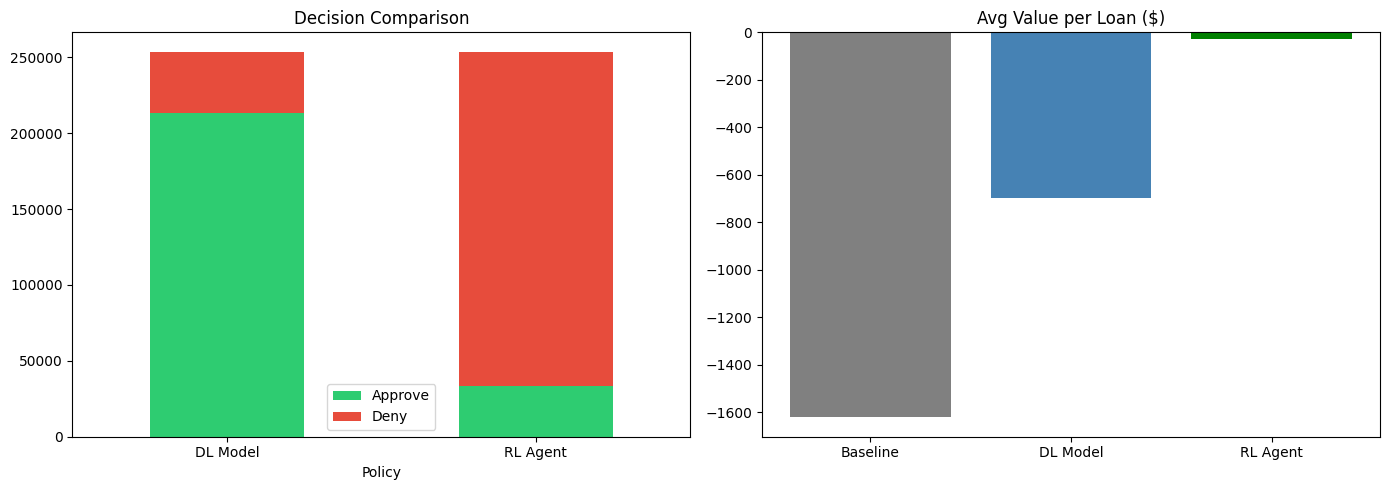


✓ Results saved: D:/PROJECTS/lending-club-ml-project/notebooks/resultsrl_model_results.csv
✓ Q-Network saved: D:/PROJECTS/lending-club-ml-project/notebooks/modelsq_network_model.pth

PART 4 COMPLETED SUCCESSFULLY!


In [20]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# STEP 8: COMPARE RL POLICY VS DL MODEL
# =============================================================================
print("\n" + "=" * 80)
print("STEP 8: Compare RL Policy vs DL Model Decisions")
print("=" * 80 + "\n")

# --- FIX: Updated Model Architecture to match the saved file (256->128->64->32) ---
class LoanDefaultMLP(nn.Module):
    def __init__(self, input_dim):
        super(LoanDefaultMLP, self).__init__()
        
        # The saved model has 4 blocks in 'hidden_layers' (indices 0 to 15)
        self.hidden_layers = nn.Sequential(
            # Block 1: 20 -> 256
            nn.Linear(input_dim, 256),      # 0
            nn.BatchNorm1d(256),            # 1
            nn.ReLU(),                      # 2
            nn.Dropout(0.3),                # 3
            
            # Block 2: 256 -> 128
            nn.Linear(256, 128),            # 4
            nn.BatchNorm1d(128),            # 5
            nn.ReLU(),                      # 6
            nn.Dropout(0.3),                # 7
            
            # Block 3: 128 -> 64
            nn.Linear(128, 64),             # 8
            nn.BatchNorm1d(64),             # 9
            nn.ReLU(),                      # 10
            nn.Dropout(0.2),                # 11
            
            # Block 4: 64 -> 32 (This was missing/wrong size before)
            nn.Linear(64, 32),              # 12
            nn.BatchNorm1d(32),             # 13
            nn.ReLU(),                      # 14
            nn.Dropout(0.2)                 # 15
        )
        
        # The saved model has a separate 'output' layer, NOT inside Sequential
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

try:
    # Initialize model
    # Note: Ensure state_dim is defined (usually 20 based on your error log)
    if 'state_dim' not in globals():
        state_dim = X_test_tensor.shape[1]
        
    dl_model = LoanDefaultMLP(state_dim).to(device)
    
    # Path handling
    model_path = 'loan_default_dl_model.pth'
    if not os.path.exists(model_path):
        model_path = 'loan_default_dl_model.pth' 

    # Load weights
    dl_model.load_state_dict(torch.load(model_path, map_location=device))
    dl_model.eval()
    print("✓ DL Model loaded successfully with correct architecture.")
    
    with torch.no_grad():
        dl_pred_proba = dl_model(X_test_tensor).squeeze().cpu().numpy()
    
    # DL policy: Deny if probability of default > 0.5
    dl_actions = (dl_pred_proba < 0.5).astype(int)
    
    print("8.1 Decision Comparison:")
    print("-" * 80)
    print(f"DL Model approvals: {np.sum(dl_actions == 1):,} ({np.mean(dl_actions)*100:.2f}%)")
    print(f"RL Policy approvals: {np.sum(rl_actions == 1):,} ({np.mean(rl_actions)*100:.2f}%)")
    
    # Find disagreements
    disagreements = rl_actions != dl_actions
    print(f"\nDecision disagreements: {np.sum(disagreements):,} ({np.mean(disagreements)*100:.2f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Decision comparison
    decision_data = pd.DataFrame({
        'Policy': ['DL Model', 'RL Agent'],
        'Approve': [np.sum(dl_actions == 1), np.sum(rl_actions == 1)],
        'Deny': [np.sum(dl_actions == 0), np.sum(rl_actions == 0)]
    }).set_index('Policy')
    
    decision_data.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_title('Decision Comparison', fontsize=12)
    axes[0].tick_params(axis='x', rotation=0)
    
    # Policy Value Comparison
    dl_rewards = np.where(dl_actions == 1, rewards_test, 0)
    dl_policy_value = np.mean(dl_rewards)
    
    policy_values = [baseline_policy_value, dl_policy_value, estimated_policy_value]
    policy_names = ['Baseline', 'DL Model', 'RL Agent']
    
    axes[1].bar(policy_names, policy_values, color=['gray', 'steelblue', 'green'])
    axes[1].set_title('Avg Value per Loan ($)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"⚠ Could not load DL model for comparison: {e}")

# Save results logic (remains the same)
results_dir = 'D:/PROJECTS/lending-club-ml-project/notebooks/results'
models_dir = 'D:/PROJECTS/lending-club-ml-project/notebooks/models'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

rl_results = pd.DataFrame({
    'Metric': ['Estimated Policy Value', 'Approval Rate', 'Baseline Policy Value'],
    'Value': [estimated_policy_value, np.mean(rl_actions)*100, baseline_policy_value]
})

rl_results.to_csv(os.path.join(results_dir, 'rl_model_results.csv'), index=False)
print(f"\n✓ Results saved: {results_dir}rl_model_results.csv")

torch.save(q_network.state_dict(), os.path.join(models_dir, 'q_network_model.pth'))
print(f"✓ Q-Network saved: {models_dir}q_network_model.pth")

print("\n" + "=" * 80)
print("PART 4 COMPLETED SUCCESSFULLY!")
print("=" * 80)